# [3주차] 심화과제 - Pre-trained 모델로 효율적인 NLP 모델 학습하기

-

In [1]:
%pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

### 1. 데이터셋 준비

Kaggle 데이터셋을 다운로드 받는다.

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedevastator/unlocking-language-understanding-with-the-multin")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/unlocking-language-understanding-with-the-multin


kaggle 데이터셋은 다음과 같이 구성되어 있다.
- premise: 기준이 되는 첫 번째 문장
- hypothesis: 두 번째 문장
- label: 두 문장의 관계
  - entailment: 논리적 연결(0)
  - contradiction: 모순 관계(1)
  - neutral: 무관한 관계(2)

In [3]:
import random
import pandas as pd

def load_data(path, nrows=None):
  df = pd.read_csv(path, nrows=nrows, keep_default_na=False)
  data = []
  for _, row in df.iterrows():
    if len(row['premise']) * len(row['hypothesis']) != 0:
      data.append({'premise': row['premise'], 'hypothesis': row['hypothesis'], 'label': row['label']})

  return data

train_data = load_data(path+'/train.csv', nrows=5000)
test_data = load_data(path+'/validation_matched.csv', nrows=5000)

print("\n=== 데이터 예시 ===")
print("첫 번째 예시:")
print(f"Premise: {train_data[0]['premise']}")
print(f"Hypothesis: {train_data[0]['hypothesis']}")
print(f"Label: {train_data[0]['label']}")

print("\n두 번째 예시:")
print(f"Premise: {train_data[1]['premise']}")
print(f"Hypothesis: {train_data[1]['hypothesis']}")
print(f"Label: {train_data[1]['label']}")


=== 데이터 예시 ===
첫 번째 예시:
Premise: Conceptually cream skimming has two basic dimensions - product and geography.
Hypothesis: Product and geography are what make cream skimming work. 
Label: 1

두 번째 예시:
Premise: you know during the season and i guess at at your level uh you lose them to the next level if if they decide to recall the the parent team the Braves decide to call to recall a guy from triple A then a double A guy goes up to replace him and a single A guy goes up to replace him
Hypothesis: You lose the things to the following level if the people recall.
Label: 0


RoBERTa 토크나이저를 불러온다.

In [4]:
from transformers import RobertaTokenizer

# RoBERTa 토크나이저 로드
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')  # 또는 'roberta-large'

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
from transformers import AutoTokenizer
import torch
from torch.utils.data import DataLoader


def collate_fn(batch):
    premises, hypotheses, labels = [], [], []

    # 배치 내 각 샘플에서 premise, hypothesis, label 추출
    for row in batch:
        premises.append(row['premise'])
        hypotheses.append(row['hypothesis'])
        labels.append(row['label'])

    # tokenizer로 두 문장을 함께 토큰화
    encoded = tokenizer(
        premises,
        hypotheses,
        padding=True,
        truncation='longest_first',
        max_length=156,
        return_tensors='pt',
        add_special_tokens=True  # RoBERTa의 special 토큰 추가
    )

    # label을 텐서로 변환한다
    labels = torch.LongTensor(labels)

    # 모델 입력에 필요한 모든 정보 반환
    return {
        'input_ids': encoded['input_ids'],
        'attention_mask': encoded['attention_mask'],
        'labels': labels
    }

batch_size = 32

# DataLoader 설정
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)

# 데이터 형태 확인
for batch in train_loader:
    print("배치 크기:", batch['input_ids'].shape)
    print("어텐션 마스크 크기:", batch['attention_mask'].shape)
    print("라벨 크기:", batch['labels'].shape)
    print("\n첫 번째 배치 예시:")
    print("입력 ID:", batch['input_ids'][0])
    print("라벨:", batch['labels'][0])
    break

배치 크기: torch.Size([32, 78])
어텐션 마스크 크기: torch.Size([32, 78])
라벨 크기: torch.Size([32])

첫 번째 배치 예시:
입력 ID: tensor([    0, 10975,   104,   742,   700,  5741,    11, 25876,     7,  1323,
          160,  7428, 15864,    25,  7371,    10,  1741,  7743,     6, 22262,
        11721,  1033,    25,   937, 30079,     6,  2241, 12949,  9622,    25,
         5616,  2956,     6,  5789,     5,   188,   469,  1513,   128,  9605,
         9691, 26452,  1182,  1543,     4,     2,     2, 40648,  9691, 26452,
         1182,  1543,   875,    11,     5,   188,   469,  1513,    14,    51,
          860,    11, 25876,     7,  1323,   160,  7428, 15864,    25,   937,
        30079,     4,     2,     1,     1,     1,     1,     1])
라벨: tensor(0)


### 2. 모델 정의

MNLI task를 위해 시퀀스 분류용 모델 RobertaForSequenceClassification을 불러온다.

In [6]:
from transformers import RobertaForSequenceClassification

model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',  # 또는 'roberta-large'
    num_labels=3,    # entailment, contradiction, neutral
    problem_type="single_label_classification", # 하나의 레이블만 선택
    classifier_dropout=0.3, # 분류기(classifier) 레이어의 dropout 비율
    attention_probs_dropout_prob=0.1,  # 어텐션 스코어에 적용되는 dropout 비율
    hidden_dropout_prob=0.1 # 트랜스포머 hidden states의 dropout 비율
)

# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


모델의 입력과 출력, 예측 결과 형태를 확인한다.

In [7]:
# 예시 데이터
premise = "Conceptually cream skimming has two basic dimensions - product and geography."
hypothesis = "Product and geography are what make cream skimming work."

# 입력 형태
encoded = tokenizer(
    premise,
    hypothesis,
    padding=True,
    truncation=True,
    max_length=124,
    return_tensors='pt'
)
encoded = {k: v.to(device) for k, v in encoded.items()}

print("=== 입력 형태 ===")
print("input_ids 형태:", encoded['input_ids'].shape)
print("attention_mask 형태:", encoded['attention_mask'].shape)

# 모델 출력
outputs = model(**encoded)
print("\n=== 출력 형태 ===")
print("로짓 형태:", outputs.logits.shape)  # [batch_size, 3] - 3개 클래스에 대한 점수

# 예측 클래스
predicted_class = torch.argmax(outputs.logits, dim=1)
print("\n=== 예측 결과 ===")
print("예측 클래스:", predicted_class.item())  # 0: entailment, 1: contradiction, 2: neutral

# 레이블과 예측값 매핑
label_map = {0: 'entailment', 1: 'contradiction', 2: 'neutral'}
print("예측 결과:", label_map[predicted_class.item()])

=== 입력 형태 ===
input_ids 형태: torch.Size([1, 30])
attention_mask 형태: torch.Size([1, 30])

=== 출력 형태 ===
로짓 형태: torch.Size([1, 3])

=== 예측 결과 ===
예측 클래스: 1
예측 결과: contradiction


### 3. Fine tuning

fine tuning 전/후를 비교하기 위해 정확도를 계산하고 모델의 성능을 평가하는 함수를 추가한다.

In [8]:
# 정확도 계산 함수
def compute_accuracy(model, data_loader, print_errors=False):
    model.eval()
    correct = 0
    total = 0

    # 오답 사례를 저장할 리스트
    error_cases = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)

            # 오답 케이스 찾기
            if print_errors:
                incorrect_indices = (predictions != labels).nonzero(as_tuple=True)[0]
                for idx in incorrect_indices:
                    # batch에서 원본 데이터 가져오기
                    original_premise = data_loader.dataset[batch_size * batch_idx + idx]['premise']
                    original_hypothesis = data_loader.dataset[batch_size * batch_idx + idx]['hypothesis']

                    error_cases.append({
                        'premise': original_premise,
                        'hypothesis': original_hypothesis,
                        'predicted': predictions[idx].item(),
                        'actual': labels[idx].item()
                    })

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    # 오답 사례 출력
    if print_errors and error_cases:
        print("\n=== 예측 실패 사례 ===")
        label_map = {0: 'entailment', 1: 'neutral', 2: 'contradiction'}
        for i, case in enumerate(error_cases[:5]):  # 처음 5개만 출력
            print(f"\n사례 {i+1}:")
            print(f"Premise: {case['premise']}")
            print(f"Hypothesis: {case['hypothesis']}")
            print(f"예측: {label_map[case['predicted']]}")
            print(f"실제: {label_map[case['actual']]}")
            print("-" * 50)

    return correct / total

# 모델 성능 평가 함수
def evaluate(model, train_loader, test_loader, title_prefix=""):
    # 정확도 계산
    train_acc = compute_accuracy(model, train_loader, print_errors=False)
    test_acc = compute_accuracy(model, test_loader, print_errors=True)

    print(f"\n=== {title_prefix} 모델 성능 ===")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")

    return train_acc, test_acc

overfitting을 방지하기 위해 early stopping을 정의한다.

In [9]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.001, max_train_acc=0.95, verbose=True):
        """
        patience: 성능 향상이 없어도 기다리는 에폭 수
        min_delta: 성능 향상으로 간주할 최소 변화량
        verbose: 상세 출력 여부
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.best_acc = None
        self.early_stop = False
        self.best_model = None
        self.max_train_acc = max_train_acc

    def __call__(self, val_loss, val_acc, train_acc, model):
        # 학습 정확도가 너무 높아지면 조기 종료
        if train_acc > self.max_train_acc:
            if self.verbose:
                print(f'Early stopping: Train accuracy ({train_acc:.4f}) exceeded threshold ({self.max_train_acc:.4f})')
            self.early_stop = True
            return

        if self.best_loss is None:  # 첫 에폭
            self.best_loss = val_loss
            self.best_acc = val_acc
            self.best_model = model.state_dict()
        elif val_loss > self.best_loss - self.min_delta:  # 성능 향상이 없는 경우
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f'Early stopping triggered! Best accuracy: {self.best_acc:.4f}')
        else:  # 성능이 향상된 경우
            self.best_loss = val_loss
            self.best_acc = val_acc
            self.best_model = model.state_dict()
            self.counter = 0

학습 함수를 정의한다.

overfitting을 방지하기 위해 early stop을 추가하고 epochs를 넉넉하게 설정하였다.

In [10]:
import torch
from torch.optim import AdamW
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import get_linear_schedule_with_warmup

# 학습 함수
def train_model(model, train_loader, test_loader):
    model = model.to(device)

    lr = 5e-6
    n_epochs = 50

    # AdamW 옵티마이저 사용 (트랜스포머 모델에 더 적합)
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.1)

    # 웜업 스케줄러 추가
    num_training_steps = len(train_loader) * n_epochs
    # 처음 10%는 학습률을 천천히 증가시키고 그 후 선형적으로 감소
    num_warmup_steps = num_training_steps // 10
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )

    # Early Stopping 초기화
    early_stopping = EarlyStopping(
        patience=3,
        min_delta=0.001,
        max_train_acc=0.95,
        verbose=True
    )

    train_losses = []
    train_accs = []
    test_accs = []

    # 그라디언트 스케일러 추가
    # Mixed Precision 학습에서 발생할 수 있는 그라디언트 소실(gradient underflow)문제를 방지하기 위함
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{n_epochs}')

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            # 학습 속도 향상 및 메모리 사용량 감소 위해 Mixed precision 학습 적용
            with torch.cuda.amp.autocast():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

            loss = outputs.loss
            total_loss += loss.item()

            # 그라디언트 스케일링 적용
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # 학습률 스케줄러 업데이트
            scheduler.step()

            progress_bar.set_postfix({'loss': loss.item()})

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)

        # 에폭마다 정확도 계산
        train_acc = compute_accuracy(model, train_loader)
        test_acc = compute_accuracy(model, test_loader)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"\nEpoch {epoch + 1}/{n_epochs}")
        print(f"Total Loss: {total_loss:.4f}")
        print(f"Average Loss: {avg_loss:.4f}")
        print(f"Train Accuracy: {train_acc:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}\n")
        print(f"Learning Rate: {scheduler.get_last_lr()[0]:.2e}\n")

        # Early Stopping 체크
        early_stopping(avg_loss, test_acc, train_acc, model)
        if early_stopping.early_stop:
            print(f"\nEarly stopping triggered at epoch {epoch + 1}")
            # 최고 성능 모델로 복원
            model.load_state_dict(early_stopping.best_model)
            break

    return train_losses, train_accs, test_accs

fine tuning 전/후 성능을 측정한다.

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai


=== 예측 실패 사례 ===

사례 1:
Premise: This site includes a list of all award winners and a searchable database of Government Executive articles.
Hypothesis: The Government Executive articles housed on the website are not able to be searched.
예측: neutral
실제: contradiction
--------------------------------------------------

사례 2:
Premise: uh i don't know i i have mixed emotions about him uh sometimes i like him but at the same times i love to see somebody beat him
Hypothesis: I like him for the most part, but would still enjoy seeing someone beat him.
예측: neutral
실제: entailment
--------------------------------------------------

사례 3:
Premise: yeah i i think my favorite restaurant is always been the one closest  you know the closest as long as it's it meets the minimum criteria you know of good food
Hypothesis: My favorite restaurants are always at least a hundred miles away from my house. 
예측: neutral
실제: contradiction
--------------------------------------------------

사례 4:
Premise: i don

Epoch 1/50:   0%|          | 0/157 [00:00<?, ?it/s]<ipython-input-10-2c3689ae2499>:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50: 100%|██████████| 157/157 [00:26<00:00,  5.83it/s, loss=1.17]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aw


Epoch 1/50
Total Loss: 177.1709
Average Loss: 1.1285
Train Accuracy: 0.2884
Test Accuracy: 0.3152

Learning Rate: 1.00e-06



Epoch 2/50: 100%|██████████| 157/157 [00:26<00:00,  5.88it/s, loss=1.17]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing t


Epoch 2/50
Total Loss: 173.8300
Average Loss: 1.1072
Train Accuracy: 0.3772
Test Accuracy: 0.3414

Learning Rate: 2.00e-06



Epoch 3/50: 100%|██████████| 157/157 [00:29<00:00,  5.36it/s, loss=0.925]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing 


Epoch 3/50
Total Loss: 169.9120
Average Loss: 1.0822
Train Accuracy: 0.5608
Test Accuracy: 0.5160

Learning Rate: 3.00e-06



Epoch 4/50: 100%|██████████| 157/157 [00:27<00:00,  5.75it/s, loss=0.915]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing 


Epoch 4/50
Total Loss: 116.1556
Average Loss: 0.7398
Train Accuracy: 0.8062
Test Accuracy: 0.7398

Learning Rate: 4.00e-06



Epoch 5/50: 100%|██████████| 157/157 [00:26<00:00,  5.93it/s, loss=0.388]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing 


Epoch 5/50
Total Loss: 82.8466
Average Loss: 0.5277
Train Accuracy: 0.8776
Test Accuracy: 0.7612

Learning Rate: 5.00e-06



Epoch 6/50: 100%|██████████| 157/157 [00:26<00:00,  5.89it/s, loss=0.358]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing 


Epoch 6/50
Total Loss: 64.1513
Average Loss: 0.4086
Train Accuracy: 0.9236
Test Accuracy: 0.7832

Learning Rate: 4.89e-06



Epoch 7/50: 100%|██████████| 157/157 [00:26<00:00,  5.91it/s, loss=0.604]
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing 


Epoch 7/50
Total Loss: 49.2112
Average Loss: 0.3134
Train Accuracy: 0.9522
Test Accuracy: 0.7912

Learning Rate: 4.78e-06

Early stopping: Train accuracy (0.9522) exceeded threshold (0.9500)

Early stopping triggered at epoch 7


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai


=== 예측 실패 사례 ===

사례 1:
Premise: 3)  Dare you rise to the occasion, like Raskolnikov, and reject the petty rules that govern lesser men?
Hypothesis: Would you rise up and defeaat all evil lords in the town?
예측: contradiction
실제: neutral
--------------------------------------------------

사례 2:
Premise: um-hum um-hum yeah well uh i can see you know it's it's it's it's kind of funny because we it seems like we loan money you know we money with strings attached and if the government changes and the country that we loan the money to um i can see why the might have a different attitude towards paying it back it's a lot us that  you know we don't really loan money to to countries we loan money to governments and it's the
Hypothesis: We don't loan a lot of money.
예측: entailment
실제: neutral
--------------------------------------------------

사례 3:
Premise: i'm not sure what the overnight low was
Hypothesis: I don't know how cold it got last night.
예측: neutral
실제: entailment
------------------

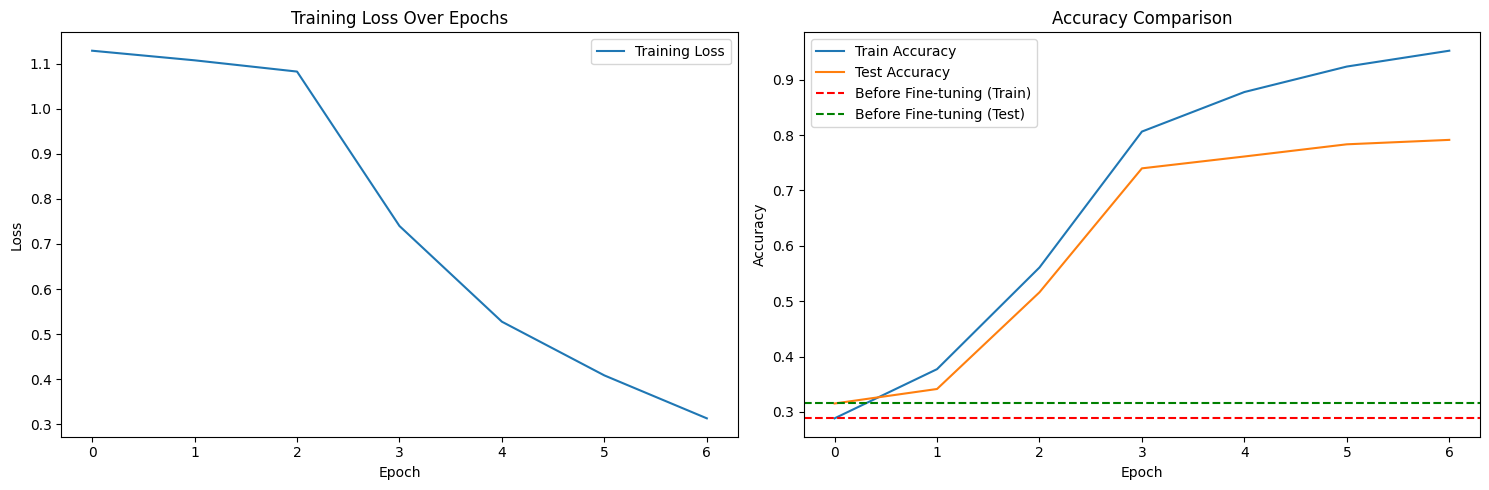


=== 성능 향상 분석 ===
Train Accuracy 향상: 66.38%
Test Accuracy 향상: 47.60%


In [11]:
# 1. Fine-tuning 전 성능 평가
before_train_acc, before_test_acc = evaluate(
    model, train_loader, test_loader, "Fine-tuning 전"
)

# 2. Fine-tuning 수행
print("\n=== Fine-tuning 시작 ===")

train_losses, train_accs, test_accs = train_model(
    model, train_loader, test_loader
)

# 3. Fine-tuning 후 성능 평가
after_train_acc, after_test_acc = evaluate(
    model, train_loader, test_loader, "Fine-tuning 후"
)

# 4. 결과 시각화
plt.figure(figsize=(15, 5))

# 학습 중 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도 비교 그래프
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.axhline(y=before_train_acc, color='r', linestyle='--', label='Before Fine-tuning (Train)')
plt.axhline(y=before_test_acc, color='g', linestyle='--', label='Before Fine-tuning (Test)')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 성능 향상 출력
print("\n=== 성능 향상 분석 ===")
print(f"Train Accuracy 향상: {(after_train_acc - before_train_acc)*100:.2f}%")
print(f"Test Accuracy 향상: {(after_test_acc - before_test_acc)*100:.2f}%")